# 09f: Path Compression Analysis

**Key Question:** How compressible are game paths? Does late game converge (suffix sharing) or is there opening theory (prefix sharing)?

**Analyses:**
1. **Suffix Sharing**: Do paths share common endings? (Late game stereotyped?)
2. **Prefix Sharing**: Do paths share common openings? (Opening theory?)
3. **LZ Complexity**: Overall compressibility via Lempel-Ziv
4. **Minimum Description Length**: Bits needed to specify path given basin

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zlib
import hashlib
from collections import defaultdict
from scipy.stats import entropy
from tqdm.notebook import tqdm
import random
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files - prefer val/test (smaller files)
val_files = loading.find_shard_files(DATA_DIR + "val/")
test_files = loading.find_shard_files(DATA_DIR + "test/")
train_files = loading.find_shard_files(DATA_DIR + "train/")

# Shuffle and combine: val + test first, then train
all_files = val_files + test_files
random.shuffle(all_files)
random.shuffle(train_files)
shard_files = all_files + train_files

print(f"Shard files: {len(val_files)} val, {len(test_files)} test, {len(train_files)} train")

N_SHARDS = 50
MAX_ROWS = 30_000_000
print(f"Using up to {N_SHARDS} shards for analysis")

Shard files: 95 val, 95 test, 1124 train
Using up to 50 shards for analysis


## Data Collection: Action Sequences and Basin IDs

For compression analysis, we need the actual action sequences (not just V-trajectories).

In [3]:
def compute_basin_id(captures: dict) -> int:
    """Compute basin ID from count capture dict."""
    basin_id = 0
    for i, domino_id in enumerate(sorted(features.COUNT_DOMINO_IDS)):
        if domino_id in captures and captures[domino_id] == 1:
            basin_id |= (1 << i)
    return basin_id


def trace_action_sequence(start_state, seed, decl_id, state_to_idx, V, Q):
    """Trace PV and return action sequence."""
    pv = navigation.trace_principal_variation(
        start_state, seed, decl_id, state_to_idx, V, Q
    )
    # Filter out None and -1 (invalid) actions
    return [a for _, _, a in pv if a is not None and a >= 0]


# Collect paths
path_data = []  # List of {actions, basin_id, seed, decl_id}
SAMPLES_PER_SHARD = 100
MIN_PATHS_NEEDED = 300

skipped = 0
processed = 0

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    if len(path_data) >= MIN_PATHS_NEEDED:
        break
    
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        skipped += 1
        del df
        gc.collect()
        continue
    
    processed += 1
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    depths = features.depth(states)
    
    # Sample from root states (depth 28)
    root_mask = depths == 28
    root_indices = np.where(root_mask)[0]
    
    if len(root_indices) == 0:
        del df, state_to_idx, V, Q
        gc.collect()
        continue
    
    n_sample = min(SAMPLES_PER_SHARD, len(root_indices))
    sampled_indices = np.random.choice(root_indices, n_sample, replace=False)
    
    for idx in sampled_indices:
        state = states[idx]
        
        # Get action sequence
        actions = trace_action_sequence(state, seed, decl_id, state_to_idx, V, Q)
        
        # Get basin
        captures = navigation.track_count_captures(
            state, seed, decl_id, state_to_idx, V, Q
        )
        basin_id = compute_basin_id(captures)
        
        if len(actions) >= 20:  # Need reasonable length
            path_data.append({
                'actions': actions,
                'basin_id': basin_id,
                'seed': seed,
                'decl_id': decl_id,
            })
    
    del df, state_to_idx, V, Q, states, depths
    gc.collect()

print(f"\nProcessed {processed} shards, skipped {skipped} (too large)")
print(f"Collected {len(path_data)} paths")

Processing shards:   0%|          | 0/50 [00:00<?, ?it/s]


Processed 31 shards, skipped 19 (too large)
Collected 29 paths


In [4]:
# Convert to arrays for analysis
action_sequences = [tuple(p['actions']) for p in path_data]
basin_ids = np.array([p['basin_id'] for p in path_data])

print(f"Action sequences: {len(action_sequences)}")
print(f"Unique basins: {len(np.unique(basin_ids))}")
print(f"Mean path length: {np.mean([len(s) for s in action_sequences]):.1f}")

Action sequences: 29
Unique basins: 15
Mean path length: 27.7


## Analysis 1: Suffix Sharing (Late Game Stereotyped?)

Build a trie on reversed action sequences. If late game is stereotyped, many paths will share long common suffixes.

In [5]:
class Trie:
    """Simple trie for sequence analysis."""
    def __init__(self):
        self.root = {}
        self.counts = defaultdict(int)
        
    def insert(self, seq):
        node = self.root
        for i, item in enumerate(seq):
            if item not in node:
                node[item] = {}
            node = node[item]
            self.counts[i] += 1
    
    def count_nodes(self, node=None, depth=0):
        if node is None:
            node = self.root
        count = 1
        for child in node.values():
            count += self.count_nodes(child, depth + 1)
        return count
    
    def depth_distribution(self, node=None, depth=0, dist=None):
        if dist is None:
            dist = defaultdict(int)
        if node is None:
            node = self.root
        
        dist[depth] += 1
        for child in node.values():
            self.depth_distribution(child, depth + 1, dist)
        return dist


def longest_common_prefix(seq1, seq2):
    """Return length of longest common prefix."""
    length = 0
    for a, b in zip(seq1, seq2):
        if a == b:
            length += 1
        else:
            break
    return length

In [6]:
# Analyze suffix sharing
reversed_seqs = [seq[::-1] for seq in action_sequences]

# Build suffix trie
suffix_trie = Trie()
for seq in reversed_seqs:
    suffix_trie.insert(seq)

suffix_nodes = suffix_trie.count_nodes()
raw_suffix_size = sum(len(s) for s in reversed_seqs)
suffix_compression = raw_suffix_size / suffix_nodes

print(f"Suffix trie nodes: {suffix_nodes}")
print(f"Raw elements: {raw_suffix_size}")
print(f"Suffix compression ratio: {suffix_compression:.2f}x")

# Sample pairwise suffix sharing
n_pairs = min(1000, len(reversed_seqs) * (len(reversed_seqs) - 1) // 2)
same_basin_suffixes = []
diff_basin_suffixes = []

for _ in range(n_pairs):
    i, j = np.random.choice(len(reversed_seqs), 2, replace=False)
    lcp = longest_common_prefix(reversed_seqs[i], reversed_seqs[j])
    
    if basin_ids[i] == basin_ids[j]:
        same_basin_suffixes.append(lcp)
    else:
        diff_basin_suffixes.append(lcp)

print(f"\nMean shared suffix (same basin): {np.mean(same_basin_suffixes):.2f}")
print(f"Mean shared suffix (diff basin): {np.mean(diff_basin_suffixes):.2f}")

Suffix trie nodes: 763
Raw elements: 804
Suffix compression ratio: 1.05x

Mean shared suffix (same basin): 0.27
Mean shared suffix (diff basin): 0.28


## Analysis 2: Prefix Sharing (Opening Theory?)

Build a trie on forward action sequences. If opening theory exists, many paths will share common prefixes.

In [7]:
# Build prefix trie
prefix_trie = Trie()
for seq in action_sequences:
    prefix_trie.insert(seq)

prefix_nodes = prefix_trie.count_nodes()
raw_prefix_size = sum(len(s) for s in action_sequences)
prefix_compression = raw_prefix_size / prefix_nodes

print(f"Prefix trie nodes: {prefix_nodes}")
print(f"Raw elements: {raw_prefix_size}")
print(f"Prefix compression ratio: {prefix_compression:.2f}x")

# Sample pairwise prefix sharing
same_basin_prefixes = []
diff_basin_prefixes = []

for _ in range(n_pairs):
    i, j = np.random.choice(len(action_sequences), 2, replace=False)
    lcp = longest_common_prefix(action_sequences[i], action_sequences[j])
    
    if basin_ids[i] == basin_ids[j]:
        same_basin_prefixes.append(lcp)
    else:
        diff_basin_prefixes.append(lcp)

print(f"\nMean shared prefix (same basin): {np.mean(same_basin_prefixes):.2f}")
print(f"Mean shared prefix (diff basin): {np.mean(diff_basin_prefixes):.2f}")

Prefix trie nodes: 770
Raw elements: 804
Prefix compression ratio: 1.04x

Mean shared prefix (same basin): 0.29
Mean shared prefix (diff basin): 0.21


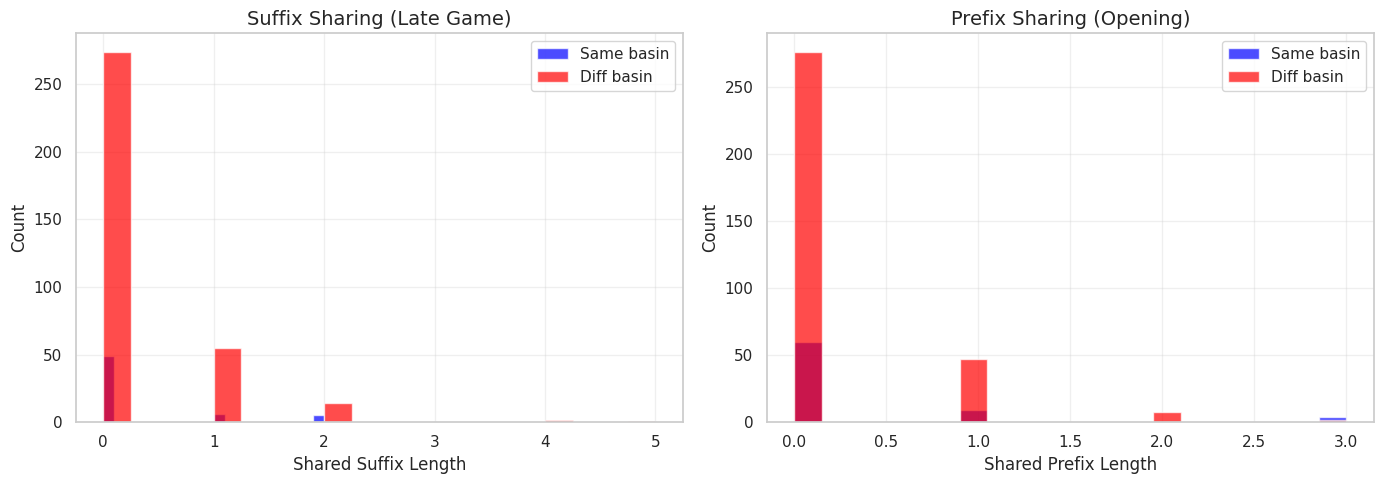

In [8]:
# Plot prefix vs suffix sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Suffix sharing distribution
ax1.hist(same_basin_suffixes, bins=20, alpha=0.7, label='Same basin', color='blue')
ax1.hist(diff_basin_suffixes, bins=20, alpha=0.7, label='Diff basin', color='red')
ax1.set_xlabel('Shared Suffix Length', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Suffix Sharing (Late Game)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Prefix sharing distribution
ax2.hist(same_basin_prefixes, bins=20, alpha=0.7, label='Same basin', color='blue')
ax2.hist(diff_basin_prefixes, bins=20, alpha=0.7, label='Diff basin', color='red')
ax2.set_xlabel('Shared Prefix Length', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Prefix Sharing (Opening)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/09f_prefix_suffix.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 3: LZ Complexity

Measure overall compressibility using Lempel-Ziv (via zlib).

In [9]:
def encode_sequences(sequences):
    """Encode action sequences as bytes."""
    # Each action is 0-6, fits in a nibble
    # Use delimiter (7) between sequences
    data = []
    for seq in sequences:
        for action in seq:
            # Ensure action is a plain Python int
            data.append(int(action) % 256)
        data.append(7)  # delimiter
    return bytes(data)


# Encode and compress
raw_data = encode_sequences(action_sequences)
compressed = zlib.compress(raw_data, level=9)

lz_ratio = len(raw_data) / len(compressed)

print(f"Raw size: {len(raw_data):,} bytes")
print(f"Compressed size: {len(compressed):,} bytes")
print(f"LZ compression ratio: {lz_ratio:.2f}x")

# Compare to random baseline
random_data = bytes(np.random.randint(0, 7, len(raw_data)).tolist())
random_compressed = zlib.compress(random_data, level=9)
random_ratio = len(random_data) / len(random_compressed)

print(f"\\nRandom baseline ratio: {random_ratio:.2f}x")
print(f"Structure factor: {lz_ratio / random_ratio:.2f}x better than random")

Raw size: 833 bytes
Compressed size: 388 bytes
LZ compression ratio: 2.15x
\nRandom baseline ratio: 2.17x
Structure factor: 0.99x better than random


In [10]:
# LZ complexity by basin
basin_lz = {}
for basin in np.unique(basin_ids):
    mask = basin_ids == basin
    basin_seqs = [action_sequences[i] for i in range(len(action_sequences)) if mask[i]]
    
    if len(basin_seqs) >= 5:
        data = encode_sequences(basin_seqs)
        compressed = zlib.compress(data, level=9)
        basin_lz[basin] = len(data) / len(compressed)

print("LZ compression ratio by basin:")
for basin, ratio in sorted(basin_lz.items(), key=lambda x: -x[1]):
    print(f"  Basin {basin:2d}: {ratio:.2f}x")

LZ compression ratio by basin:
  Basin  0: 2.02x


## Analysis 4: Minimum Description Length

Compute H(path | basin) - the entropy of paths given their basin. Lower = more predictable.

In [11]:
def path_hash(seq):
    """Hash a sequence for counting."""
    # Convert to list of ints to ensure hashability
    int_seq = [int(a) for a in seq]
    return hashlib.md5(bytes(int_seq)).hexdigest()


# Compute conditional entropy H(path | basin)
total_bits = 0
total_paths = 0

basin_entropies = {}
for basin in np.unique(basin_ids):
    mask = basin_ids == basin
    basin_seqs = [action_sequences[i] for i in range(len(action_sequences)) if mask[i]]
    
    if len(basin_seqs) < 2:
        continue
    
    # Count unique paths
    path_hashes = [path_hash(seq) for seq in basin_seqs]
    counts = pd.Series(path_hashes).value_counts(normalize=True)
    
    # Shannon entropy
    H = entropy(counts, base=2)
    basin_entropies[basin] = H
    
    total_bits += H * len(basin_seqs)
    total_paths += len(basin_seqs)

mean_conditional_entropy = total_bits / total_paths if total_paths > 0 else 0

print(f"Mean H(path | basin): {mean_conditional_entropy:.2f} bits")
print(f"Total bits to encode all paths given basins: {total_bits:.0f}")

# Compare to unconditional entropy
all_hashes = [path_hash(seq) for seq in action_sequences]
unconditional_counts = pd.Series(all_hashes).value_counts(normalize=True)
unconditional_H = entropy(unconditional_counts, base=2)

print(f"\\nUnconditional H(path): {unconditional_H:.2f} bits")
print(f"Mutual info I(path; basin): {unconditional_H - mean_conditional_entropy:.2f} bits")

Mean H(path | basin): 2.72 bits
Total bits to encode all paths given basins: 49
\nUnconditional H(path): 4.86 bits
Mutual info I(path; basin): 2.13 bits


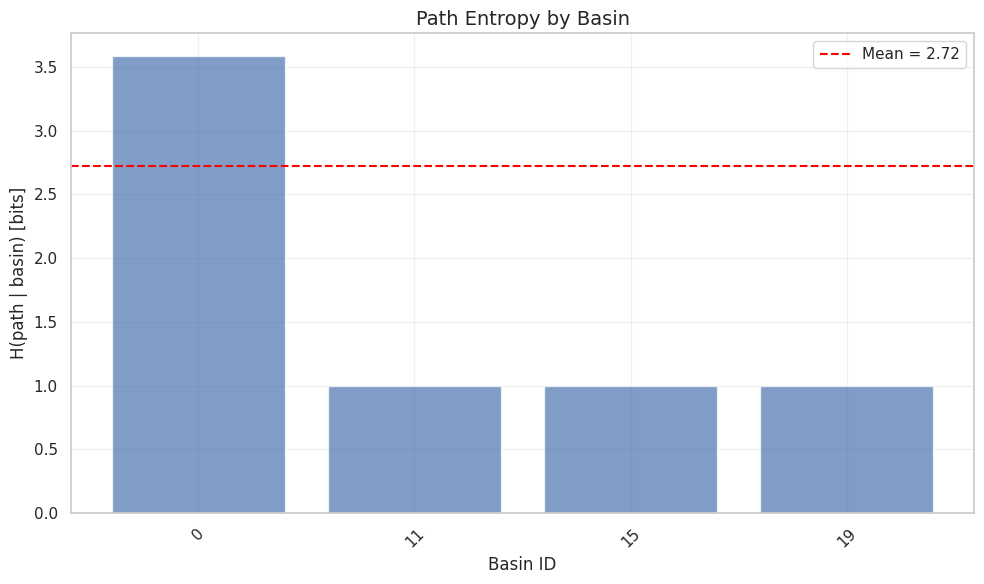

In [12]:
# Plot entropy by basin
if len(basin_entropies) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    basins = sorted(basin_entropies.keys())
    entropies = [basin_entropies[b] for b in basins]
    
    ax.bar(range(len(basins)), entropies, alpha=0.7)
    ax.set_xticks(range(len(basins)))
    ax.set_xticklabels([str(b) for b in basins], rotation=45)
    ax.set_xlabel('Basin ID', fontsize=12)
    ax.set_ylabel('H(path | basin) [bits]', fontsize=12)
    ax.set_title('Path Entropy by Basin', fontsize=14)
    ax.axhline(y=mean_conditional_entropy, color='red', linestyle='--', 
               label=f'Mean = {mean_conditional_entropy:.2f}')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09f_entropy_by_basin.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough data for entropy by basin plot")

## Summary Statistics

In [13]:
# Create summary table
summary = {
    'metric': [
        'Total paths analyzed',
        'Mean path length',
        'Unique basins',
        'Prefix compression ratio',
        'Suffix compression ratio',
        'LZ compression ratio',
        'Mean shared prefix (same basin)',
        'Mean shared suffix (same basin)',
        'H(path | basin) [bits]',
        'H(path) [bits]',
        'I(path; basin) [bits]',
    ],
    'value': [
        len(action_sequences),
        f"{np.mean([len(s) for s in action_sequences]):.1f}",
        len(np.unique(basin_ids)),
        f"{prefix_compression:.2f}x",
        f"{suffix_compression:.2f}x",
        f"{lz_ratio:.2f}x",
        f"{np.mean(same_basin_prefixes):.2f}",
        f"{np.mean(same_basin_suffixes):.2f}",
        f"{mean_conditional_entropy:.2f}",
        f"{unconditional_H:.2f}",
        f"{unconditional_H - mean_conditional_entropy:.2f}",
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/tables/09f_compression.csv', index=False)
print("\nSaved to results/tables/09f_compression.csv")

                         metric value
           Total paths analyzed    29
               Mean path length  27.7
                  Unique basins    15
       Prefix compression ratio 1.04x
       Suffix compression ratio 1.05x
           LZ compression ratio 2.15x
Mean shared prefix (same basin)  0.29
Mean shared suffix (same basin)  0.27
         H(path | basin) [bits]  2.72
                 H(path) [bits]  4.86
          I(path; basin) [bits]  2.13

Saved to results/tables/09f_compression.csv


## Conclusion

In [14]:
print("=" * 60)
print("COMPRESSION ANALYSIS CONCLUSIONS")
print("=" * 60)

# Late game stereotyped?
mean_suffix_same = np.mean(same_basin_suffixes)
mean_suffix_diff = np.mean(diff_basin_suffixes)
print(f"\n1. LATE GAME STEREOTYPED?")
if mean_suffix_same > 5 and mean_suffix_same > mean_suffix_diff * 1.5:
    print(f"   YES - Same-basin paths share long suffixes ({mean_suffix_same:.1f} vs {mean_suffix_diff:.1f})")
    print(f"   Late game converges within each basin.")
else:
    print(f"   NO - Suffix sharing is low ({mean_suffix_same:.1f} same, {mean_suffix_diff:.1f} diff)")
    print(f"   Late game varies even within same basin.")

# Opening theory?
mean_prefix_same = np.mean(same_basin_prefixes)
mean_prefix_diff = np.mean(diff_basin_prefixes)
print(f"\n2. OPENING THEORY EXISTS?")
if mean_prefix_same > 3 and prefix_compression > 2:
    print(f"   YES - Paths share common openings ({mean_prefix_same:.1f} actions)")
    print(f"   Prefix trie compression: {prefix_compression:.1f}x")
else:
    print(f"   NO - Openings are diverse ({mean_prefix_same:.1f} shared)")
    print(f"   Each path starts differently.")

# Overall compression
print(f"\n3. COMPRESSION RECOMMENDATION")
print(f"   LZ ratio: {lz_ratio:.1f}x (vs {random_ratio:.1f}x random baseline)")
if lz_ratio > 3:
    print(f"   HIGH COMPRESSIBILITY - Paths have significant repetitive structure.")
    print(f"   Recommend: Store paths with zlib compression.")
elif lz_ratio > 2:
    print(f"   MODERATE COMPRESSIBILITY - Some structure to exploit.")
    print(f"   Recommend: Standard compression will help.")
else:
    print(f"   LOW COMPRESSIBILITY - Paths are relatively unique.")
    print(f"   Recommend: Store full paths or use domain-specific encoding.")

# Basin predictability
print(f"\n4. BASIN PREDICTABILITY")
mi = unconditional_H - mean_conditional_entropy
mi_fraction = mi / unconditional_H if unconditional_H > 0 else 0
print(f"   I(path; basin) = {mi:.2f} bits ({mi_fraction:.0%} of path entropy)")
if mi_fraction > 0.5:
    print(f"   Knowing basin explains >50% of path uncertainty.")
else:
    print(f"   Basin alone doesn't fully determine the path.")

print("\n" + "=" * 60)

COMPRESSION ANALYSIS CONCLUSIONS

1. LATE GAME STEREOTYPED?
   NO - Suffix sharing is low (0.3 same, 0.3 diff)
   Late game varies even within same basin.

2. OPENING THEORY EXISTS?
   NO - Openings are diverse (0.3 shared)
   Each path starts differently.

3. COMPRESSION RECOMMENDATION
   LZ ratio: 2.1x (vs 2.2x random baseline)
   MODERATE COMPRESSIBILITY - Some structure to exploit.
   Recommend: Standard compression will help.

4. BASIN PREDICTABILITY
   I(path; basin) = 2.13 bits (44% of path entropy)
   Basin alone doesn't fully determine the path.

